In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()

In [2]:
# We will use torchvision and torch.utils.data packages for loading the data.

# The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

# This dataset is a very small subset of imagenet.

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms={
            'train':transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ]),
            'val':transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ]),
}
# data_dir='data/hymenoptera_data'
# #ImageFolder假设所有的文件按文件夹保存好，每个文件夹下面存贮同一类别的图片，文件夹的名字为分类的名字
# image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}
# dataloaders={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True,num_workers=4) for x in ['train','val']}

# dataset_sizes={x:len(image_datasets[x]) for x in ['train','val']}

# class_names=image_datasets['train'].classes

# device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

datatransit_train=torchvision.datasets.CIFAR100(root='./data',train=True,download=True,transform=data_transforms['train'])
datatransit_val=torchvision.datasets.CIFAR100(root='./data',train=False,download=True,transform=data_transforms['val'])

trainloader=torch.utils.data.DataLoader(datatransit_train,batch_size=128,shuffle=True,num_workers=2)
testloader=torch.utils.data.DataLoader(datatransit_val,batch_size=128,shuffle=False,num_workers=0)
dataloaders={'train':trainloader,'val':testloader}
dataset_sizes={'train':50000,'val':10000}
print(datatransit_val)


Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR100
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


KeyboardInterrupt: 

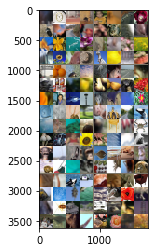

In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
dataiter= iter(dataloaders['train'])
inputs,classes=dataiter.next()
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, None)

In [6]:
def train_model(model,criterion,optimizer,scheduler,num_epochs=25):
    since=time.time()
    
    best_model_wts=copy.deepcopy(model.state_dict())
    best_acc=0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)

        for phase in ['train','val']:
            if phase=='train':
                model.train()
            else:
                model.eval()
            running_loss=0.0
            running_corrects=0
            
            for inputs,labels in dataloaders[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs=model(inputs)
                    _,preds=torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                    
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==labels.data)
            if phase=='train':
                scheduler.step()
            epoch_loss=running_loss/dataset_sizes[phase]
            epoch_acc=running_corrects.double()/dataset_sizes[phase]

            print('{} Loss:{:.4f} Acc:{:.4f}'.format(phase,epoch_loss,epoch_acc))

            if phase=='val' and epoch_acc>best_acc:
                best_acc=epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())
        print()
    time_elapsed=time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best val Acc:{:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model


In [6]:
#Generic function to display predictions for a few images
def visualize_model(model,num_images=6):
    was_training=model.training   #True/False
    model.eval()
    images_so_far=0
    fig=plt.figure()
    
    with torch.no_grad():
        for i,(inputs,labels) in enumerate(dataloaders['val']):
            inputs,labels=inputs.to(device),labels.to(device)
            outputs=model(inputs)
            _,preds=torch.max(outputs,1)
            
            for j in range(inputs.size(0)):
                images_so_far+=1
                ax=plt.subplot(num_images//2,2,images_so_far)
                ax.axis("off")
                ax.set_title('predicted:{}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far==num_images:
                    model.train(mode=was_training)
                    return 
        model.train(mode=was_training)
    

In [4]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft=models.resnet18(pretrained=True)
num_ftrs=model_ft.fc.in_features
model_ft.fc=nn.Linear(num_ftrs,100)


model_ft=model_ft.to(device)

criterion=nn.CrossEntropyLoss()

optimizer_ft=optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)
#等间隔调整学习率，调整倍数为gamma倍，调整间隔为step_size。间隔单位是step。需要注意的是，step通常是指epoch，不要弄成iteration了。
#step_size(int)- 学习率下降间隔数，若为30，则会在30、60、90......个step时，将学习率调整为lr*gamma。
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_ft,step_size=30,gamma=0.1)

In [5]:
from ptflops import get_model_complexity_info
macs, params = get_model_complexity_info(model_ft, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)

print('Flops:{}'.format(macs))
print('params:'+params)

ResNet(
  11.228 M, 100.000% Params, 1.822 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.009 M, 0.084% Params, 0.118 GMac, 6.478% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(0.0 M, 0.001% Params, 0.002 GMac, 0.088% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0.0 M, 0.000% Params, 0.001 GMac, 0.044% MACs, inplace)
  (maxpool): MaxPool2d(0.0 M, 0.000% Params, 0.001 GMac, 0.044% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    0.148 M, 1.318% Params, 0.465 GMac, 25.516% MACs, 
    (0): BasicBlock(
      0.074 M, 0.659% Params, 0.232 GMac, 12.758% MACs, 
      (conv1): Conv2d(0.037 M, 0.328% Params, 0.116 GMac, 6.346% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(0.0 M, 0.001% Params, 0.0 GMac, 0.022% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

In [8]:
model_result=train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=25)


Epoch 0/24
----------


RuntimeError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 4.00 GiB total capacity; 2.97 GiB already allocated; 5.26 MiB free; 22.46 MiB cached)

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv=torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requiers_grad=False
num_ftrs=model_conv.fc.in_features
model_conv.fc=nn.Linear(num_ftrs,2)
model_conv=model_conv.to(device)

criterion=nn.CrossEntropyLoss()
optimizer_cov=optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_cov,step_size=7,gamma=0.1)


In [ ]:
model_conv=train_model(model_conv,criterion,optimizer_cov,exp_lr_scheduler,num_epochs=25)


In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()